# Collaborative filtering approach : Systèmes de Recommandation

## 1). Importer en nettoyer le jeu de données MovieLens 1M

Dans cette section, nous utilisons le jeu de données **MovieLens 1M**, une base de données publique contenant **1 million de notations** de films réalisées par environ **6 000 utilisateurs** sur plus de **3 900 films**.

Ces données sont largement utilisées pour l’expérimentation et la recherche dans les **systèmes de recommandation** basés sur le **filtrage collaboratif**.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
import os
import zipfile
import urllib.request

DATA_URL = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
ZIP_PATH = "ml-1m.zip"
EXTRACT_PATH = "ml-1m"

def download_movielens():
    if not os.path.exists(ZIP_PATH):
        print("Téléchargement du dataset MovieLens...")
        urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
        print("Téléchargement terminé.")

    if not os.path.exists(EXTRACT_PATH):
        print("Extraction des fichiers...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Extraction terminée.")

if __name__ == "__main__":
    download_movielens()


Suite à l'importation et au nettoyage des données MovieLens 1M, nous obtenons les trois DataFrames suivants :

##### a). `users`

| Colonne | Description |
| :--- | :--- |
| `UserID` | Identifiant unique de l’utilisateur |
| `Gender` | Sexe (`M` ou `F`) |
| `Age` | Tranche d’âge (ex : 18, 25, 35, etc.) |
| `Occupation` | Code numérique de profession |
| `Zip-code` | Code postal (principalement US) |



##### b). `movies`

| Colonne | Description |
| :--- | :--- |
| `MovieID` | Identifiant unique du film |
| `Title` | Titre du film avec l’année de sortie |
| `Genres` | Liste des genres associés (séparés par `|`, ex : `Comedy|Romance`) |



##### c). `ratings`

| Colonne | Description |
| :--- | :--- |
| `UserID` | Identifiant de l’utilisateur ayant noté le film |
| `MovieID` | Identifiant du film noté |
| `Rating` | Note attribuée (de 1 à 5) |
| `Timestamp` | Date/heure de la notation (au format Unix) |



In [3]:
df_user_info = pd.read_csv("/home/onyxia/work/projet_python_films/Data processing/ml-1m/ml-1m/users.dat",
    sep="::",
    engine="python",  
    names=["UserID", "Gender", "Age", "Occupation", "Zip-code"]
)

df_user_info

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [4]:
df_films = pd.read_csv(
    "/home/onyxia/work/projet_python_films/Data processing/ml-1m/ml-1m/movies.dat",
    sep="::",
    engine="python",
    names=["MovieID", "Title", "Genres"], 
    encoding="ISO-8859-1"
)

df_films


,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [5]:
df_ratings = pd.read_csv(
    "/home/onyxia/work/projet_python_films/Data processing/ml-1m/ml-1m/ratings.dat",
    sep="::",
    engine="python",
    names=["UserID", "MovieID", "Rating", "Timestamp"],
    encoding="ISO-8859-1"  # important for accented characters
)

df_ratings


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


#### Processus de Fusion des Données

Pour créer le jeu de données unique `df_users` regroupant toutes les informations nécessaires (notations, utilisateurs, et films), nous avons effectué une série de fusions (merges) en utilisant la fonction `pd.merge()` de pandas :

1.  **Fusion `df_ratings` et `df_user_info`** : Les notations sont jointes aux informations des utilisateurs via la clé commune `UserID`.
2.  **Fusion du résultat avec `df_films`** : Le DataFrame intermédiaire est ensuite joint aux informations sur les films via la clé `MovieID`.

Cette approche nous donne un DataFrame monolithique où chaque ligne représente une **notation unique** et contient toutes les informations contextuelles de l'utilisateur et du film.

In [6]:
# Harmoniser les types de clé avant la fusion
df_ratings["MovieID"] = df_ratings["MovieID"].astype(int)
df_user_info["UserID"] = df_user_info["UserID"].astype(int)
df_films["MovieID"] = df_films["MovieID"].astype(int)

# Fusion
df_users = (
    df_ratings
    .merge(df_user_info, on="UserID")
    .merge(df_films, on="MovieID")
)

df_users

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106,Weekend at Bernie's (1989),Comedy
1000205,6040,1094,5,956704887,M,25,6,11106,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,956704746,M,25,6,11106,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,956715648,M,25,6,11106,Sophie's Choice (1982),Drama


### Nettoyage des données

In [7]:
# Function to clean the data 
def clean_df(df): 
    # Drop 'Timestep' column
    df.drop(columns=["Timestamp"])
    # Convert 'Genres' string to list
    df["Genres"] = df["Genres"].apply(lambda x: x.split("|") if isinstance(x, str) else [])
    # Transform 'Gender' to binary values 
    df["Gender"] = df["Gender"].apply(lambda x: 1 if x == "F" else 0)
    return df

# Apply to df_users 
df_users=clean_df(df_users)

# Check result
df_users.head()


,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
0,1,1193,5,978300760,1,1,10,48067,One Flew Over the Cuckoo's Nest (1975),[Drama]
1,1,661,3,978302109,1,1,10,48067,James and the Giant Peach (1996),"[Animation, Children's, Musical]"
2,1,914,3,978301968,1,1,10,48067,My Fair Lady (1964),"[Musical, Romance]"
3,1,3408,4,978300275,1,1,10,48067,Erin Brockovich (2000),[Drama]
4,1,2355,5,978824291,1,1,10,48067,"Bug's Life, A (1998)","[Animation, Children's, Comedy]"


In [8]:
df_users["Age"].value_counts()

Age
25    395556
35    199003
18    183536
45     83633
50     72490
56     38780
1      27211
Name: count, dtype: int64

## 2). Visualiser les données 

### Exploring the user base

In [9]:
# Number of users 
total_users = df_users["UserID"].nunique()
print("Total number of unique users:", total_users)

Total number of unique users: 6040


Gender
Female    4331
Male      1709
Name: UserID, dtype: int64


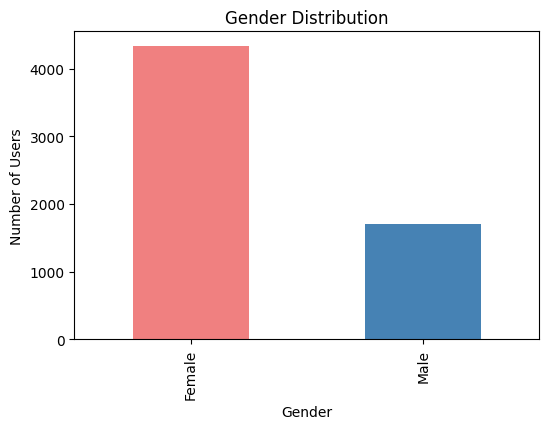

In [10]:
# Number of men and women
gender_counts = df_users.groupby("Gender")["UserID"].nunique().rename({1: "Male", 0: "Female"})
print(gender_counts)

plt.figure(figsize=(6, 4))
gender_counts.plot(kind="bar", color=["lightcoral", "steelblue"])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.show()



In [11]:
# Age distribution

# Count unique users per age code
age_counts = (
    df_users.groupby("Age")["UserID"].nunique()
    .rename_axis("Age")
    .reset_index(name="UserCount")
)

# Define mapping for all expected codes
age_labels = {
    0: "Under 18",
    1: "18-24",
    2: "25-34",
    3: "35-44",
    4: "45-49",
    5: "50-55",
    6: "56+"
}

# Replace codes with readable labels, drop unexpected or missing ages
age_counts["AgeGroup"] = age_counts["Age"].map(age_labels)

# Make sure labels are ordered correctly
order = ["Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"]
age_counts["AgeGroup"] = pd.Categorical(age_counts["AgeGroup"], categories=order, ordered=True)

# Sort and ensure proper string dtype for plotting
age_counts = age_counts.sort_values("AgeGroup")
age_counts["AgeGroup"] = age_counts["AgeGroup"].astype(str)

""" # Plot
plt.figure(figsize=(8, 5))
plt.bar(age_counts["AgeGroup"], age_counts["UserCount"], color="cornflowerblue")
plt.title("User Distribution by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.show() """

print(age_counts)

   Age  UserCount AgeGroup
0    1        222    18-24
1   18       1103      nan
2   25       2096      nan
3   35       1193      nan
4   45        550      nan
5   50        496      nan
6   56        380      nan


### Exploring the movie base

In [12]:
# Number of movies 


In [13]:
# Movie genres 

### Rating analysis

In [14]:
# Movies with the biggest number of ratings

In [15]:
# Highest ranked movies on average 

In [16]:
# Favourite genres by sex

In [17]:
# Favourite genres by age 

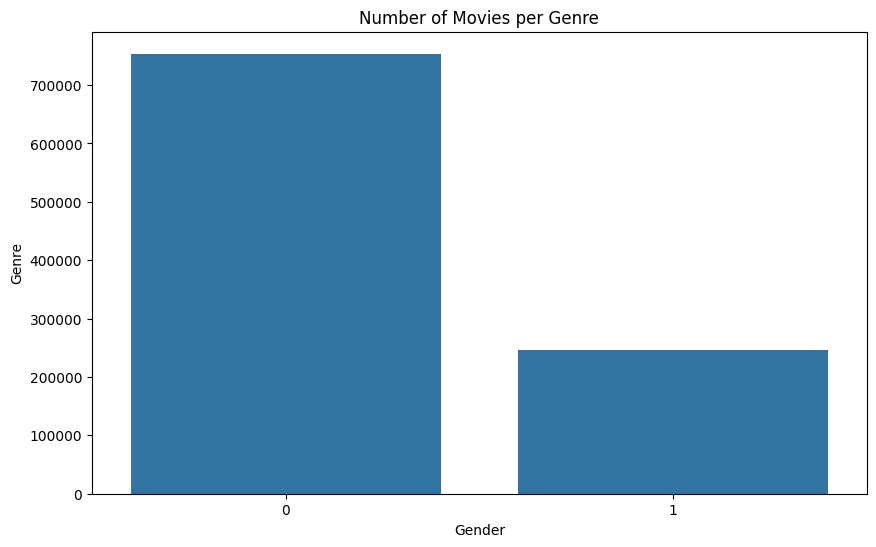

Gender
0    753769
1    246440
Name: count, dtype: int64


In [18]:

df_exploded_genders = df_users.explode('Gender')

gender_counts = df_exploded_genders['Gender'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title("Number of Movies per Genre")
plt.xlabel("Gender")
plt.ylabel("Genre")
plt.show()

print(gender_counts)

### Age

### Genre

## 3). Modelling : Approche par Filtrage Collaboratif

L'étape de visualisation des données a permis de comprendre la distribution des utilisateurs (par âge et genre) et la nature des notations. Nous passons maintenant à la construction du modèle de recommandation en utilisant une approche de **filtrage collaboratif basée sur la factorisation matricielle** (Matrix Factorization) implémentée avec PyTorch.

Le principe est d'apprendre :
* Une matrice de **caractéristiques de films** ($\mathbf{X}$, *Movie Feature Matrix*).
* Une matrice de **préférences utilisateurs** ($\mathbf{W}$, *User Parameter Matrix*).

Tel que la prédiction de notation pour un film $i$ par un utilisateur $j$ soit donnée par :
$$\text{Prédiction}(\mathbf{i}, \mathbf{j}) \approx (\mathbf{X} \mathbf{W}^T)_{ij} + b_j + \mu_i$$
où $b_j$ est le biais utilisateur et $\mu_i$ est la note moyenne du film (déjà soustraite lors de la normalisation).

### 4.1). Setup et Pré-traitement des Données

In [19]:
!pip install torch torchvision torchaudio

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

#### Création des Matrices Fondamentales

La modélisation par factorisation matricielle nécessite deux matrices principales dérivées du jeu de données agrégé :

1.  **Matrice de Notation ($\mathbf{Y}$)** :
    * Elle est créée en pivotant le DataFrame, avec les **films en lignes** et les **utilisateurs en colonnes**.
    * Les valeurs manquantes (films non notés) sont remplies avec **0**.
    * Sa forme est $(\text{Nombre de Films} \times \text{Nombre d'Utilisateurs})$.

2.  **Matrice Indicatrice ($\mathbf{R}$)** :
    * C'est une matrice binaire de même forme que $\mathbf{Y}$.
    * $\mathbf{R}_{ij} = 1$ si l'utilisateur $j$ a noté le film $i$.
    * $\mathbf{R}_{ij} = 0$ sinon. Elle sert de masque pour calculer les erreurs uniquement sur les notations existantes.

In [21]:
# 1. Pivot to Y (Rating Matrix): Movies as index, Users as columns
Y_df = df_users.pivot_table(index='MovieID', columns='UserID', values='Rating').fillna(0)
Y = Y_df.values # Convert to NumPy array

# 2. Create R (Indicator Matrix): 1 if rating > 0, 0 otherwise
R = (Y > 0).astype(int)

# 3. Create Movie List (using the pivoted index for correct ordering)
movieList_df = df_users[['MovieID', 'Title']].drop_duplicates(subset=['MovieID']).set_index('MovieID').reindex(Y_df.index)
movieList = movieList_df['Title'].tolist()

num_movies, num_users = Y.shape
print(f"Y matrix shape (movies x users): {Y.shape}")
print(f"R matrix shape (movies x users): {R.shape}")

Y matrix shape (movies x users): (3706, 6040)
R matrix shape (movies x users): (3706, 6040)


#### Normalisation des Notations

Pour améliorer la convergence et la robustesse du modèle (en particulier pour gérer les différences dans les moyennes de notation des films), nous appliquons la **normalisation des notations** :

* Nous calculons la **note moyenne globale** ($\mathbf{Y}_{\text{mean}}$) pour chaque film $i$, en se basant uniquement sur les utilisateurs qui l'ont noté.
* La matrice de notation normalisée ($\mathbf{Y}_{\text{norm}}$) est obtenue en soustrayant la moyenne de chaque notation existante :
    $$\mathbf{Y}_{\text{norm}}(i,j) = \mathbf{Y}(i,j) - \mathbf{Y}_{\text{mean}}(i), \quad \text{si} \ \mathbf{R}(i,j) = 1$$
* Les prédictions finales seront donc la prédiction normalisée **plus** la moyenne du film $\mathbf{Y}_{\text{mean}}$.

In [22]:
def normalizeRatings(Y, R):
    """
    Normalizes Y (ratings) by subtracting the mean rating for each movie, 
    calculated only from movies that have been rated (R=1).
    """
    nm, nu = Y.shape
    Ymean = np.zeros((nm, 1))
    Ynorm = np.zeros((nm, nu))
    
    for i in range(nm):
        idx = np.where(R[i, :] == 1)[0]
        if len(idx) > 0:
            mean_rating = np.mean(Y[i, idx])
            Ymean[i] = mean_rating
            Ynorm[i, idx] = Y[i, idx] - mean_rating
            
    return Ynorm, Ymean

In [23]:
Ynorm_np, Ymean_np = normalizeRatings(Y, R)

# Convert NumPy arrays to PyTorch Tensors for training
Ynorm = torch.from_numpy(Ynorm_np)
R = torch.from_numpy(R)

### 4.2). Fonction de Coût du Filtrage Collaboratif (J)

La fonction de coût **vectorisée** que nous cherchons à minimiser est l'erreur quadratique moyenne (MSE) sur les notations existantes, augmentée d'un terme de régularisation pour prévenir le surapprentissage.

#### L'Expression du Coût

La fonction de coût $J(\mathbf{X}, \mathbf{W}, \mathbf{b})$ en PyTorch est donnée par :

$$J(\mathbf{X}, \mathbf{W}, \mathbf{b}) = \frac{1}{2} \sum_{(i,j):\mathbf{R}_{ij}=1} \left( (\mathbf{X}_i \cdot \mathbf{W}_j^T + b_j) - \mathbf{Y}_{\text{norm}, ij} \right)^2 + \frac{\lambda}{2} \sum_{i,k} (\mathbf{X}_{i,k})^2 + \frac{\lambda}{2} \sum_{j,k} (\mathbf{W}_{j,k})^2$$

* **Terme d'Erreur (Erreur Quadratique)** :
    * $\mathbf{X} \mathbf{W}^T + \mathbf{b}$ est la matrice de prédiction pour toutes les paires film-utilisateur.
    * $\mathbf{Y}_{\text{norm}}$ est la matrice de notation normalisée.
    * Nous multiplions par $\mathbf{R}$ pour ne considérer que les erreurs des films effectivement notés.

* **Terme de Régularisation ($\mathbf{\lambda}$)** :
    * Les deux derniers termes appliquent une régularisation $\mathbf{L2}$ aux matrices de caractéristiques $\mathbf{X}$ et de paramètres $\mathbf{W}$.
    * Ceci permet de maintenir des caractéristiques (features) et des paramètres petits, évitant ainsi un surajustement des données d'entraînement.

In [24]:
def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Returns the cost for collaborative filtering (Vectorized) using PyTorch.
    """
    
    # 1. Squared Error Term
    # Prediction P = X @ W.T + b. 
    # P has shape (num_movies, num_users)
    P = torch.matmul(X, W.T) + b
    
    # Error only for rated movies (multiplied by R)
    J_error = (P - Y) * R
    
    # Squared Error Term
    J = 0.5 * torch.sum(J_error**2)
    
    # 2. Regularization Term: (lambda/2) * (sum(W^2) + sum(X^2))
    J_reg = (lambda_/2) * (torch.sum(X**2) + torch.sum(W**2))
    
    return J + J_reg

### 4.3). Initialisation des Paramètres et Configuration de l'Optimiseur

L'entraînement du modèle par PyTorch nécessite l'initialisation des tenseurs qui stockent les paramètres à apprendre.

| Paramètre | Symbole | Taille | Description |
| :--- | :--- | :--- | :--- |
| **Caractéristiques Films** | $\mathbf{X}$ | $(\text{nm} \times \text{nf})$ | $nm$: Nombre de films (3706). $nf$: Nombre de caractéristiques (200). |
| **Paramètres Utilisateurs** | $\mathbf{W}$ | $(\text{nu} \times \text{nf})$ | $nu$: Nombre d'utilisateurs (6040). $nf$: Nombre de caractéristiques (200). |
| **Biais Utilisateurs** | $\mathbf{b}$ | $(1 \times \text{nu})$ | Ajustement de la note pour chaque utilisateur. |

#### Choix des Hyperparamètres

* **Nombre de Caractéristiques ($\text{num\_features}$) = 200** : Un nombre plus élevé permet de capturer des relations plus complexes entre les films et les utilisateurs, mais augmente le risque de surapprentissage et le temps de calcul. **200** est un bon compromis.
* **Paramètre de Régularisation ($\lambda$) = 1.0** : Ce terme contrôle l'importance de la régularisation L2. $\lambda=1.0$ est une valeur initiale courante qui introduit une pénalité modérée sur l'amplitude des paramètres.
* **Taux d'Apprentissage ($\text{learning\_rate}$) = 0.01** : Un taux d'apprentissage modéré pour l'optimiseur **Adam**, souvent efficace pour la factorisation matricielle. L'optimiseur **Adam** ajuste automatiquement les taux d'apprentissage des différents paramètres pour une convergence plus rapide et stable.

In [25]:
# Parameters for training
num_features = 200 
lambda_ = 1.0      # Regularization parameter
learning_rate = 0.1 # Learning rate 

# Set seed for consistent results
torch.manual_seed(1234)

# Initialize trainable parameters as PyTorch nn.Parameter
W = nn.Parameter(torch.randn(num_users, num_features), requires_grad=True)
X = nn.Parameter(torch.randn(num_movies, num_features), requires_grad=True)
b = nn.Parameter(torch.randn(1, num_users), requires_grad=True)

# Instantiate the Adam optimizer, targeting all trainable parameters
optimizer = optim.Adam([W, X, b], lr=learning_rate)

### 4.5). Entraînement du Modèle

Le modèle est entraîné par la méthode de la **descente de gradient stochastique (SGD)**, orchestrée par l'optimiseur **Adam** et implémentée via le mécanisme d'**autogradient** de PyTorch :

1.  **Réinitialisation des Gradients** : `optimizer.zero_grad()` vide les gradients accumulés de l'itération précédente.
2.  **Passage Avant (Forward Pass)** : `cost_value = cofi_cost_func_v(...)` calcule la matrice de prédiction $(\mathbf{X} \mathbf{W}^T + \mathbf{b})$ et évalue le coût $J$.
3.  **Rétropropagation (Backward Pass)** : `cost_value.backward()` calcule les gradients $\frac{\partial J}{\partial \mathbf{X}}$, $\frac{\partial J}{\partial \mathbf{W}}$, et $\frac{\partial J}{\partial \partial \mathbf{b}}$ en utilisant la règle de la chaîne.
4.  **Mise à Jour des Paramètres** : `optimizer.step()` utilise les gradients calculés pour ajuster les tenseurs $\mathbf{X}$, $\mathbf{W}$, et $\mathbf{b}$ dans la direction qui minimise le coût.

L'objectif de cette phase est de trouver les valeurs optimales pour $\mathbf{X}$, $\mathbf{W}$, et $\mathbf{b}$ qui minimisent $J$, permettant ainsi à la matrice de prédiction $\mathbf{P} \approx \mathbf{Y}_{\text{norm}}$ sur les notations observées. La diminution du coût loguée montre la convergence de l'algorithme.

In [26]:
iterations = 1000

print("\nStarting Collaborative Filtering Training (PyTorch)...")

for iter in range(iterations):
    # 1. Zero the gradients
    optimizer.zero_grad()
    
    # 2. Forward pass: compute the cost
    cost_value = cofi_cost_func_v(X, W, b, Ynorm, R, lambda_)
    
    # 3. Backward pass: compute gradient
    cost_value.backward()
    
    # 4. Update parameters
    optimizer.step()

    # Log periodically
    if iter % 20 == 0:
        # Use .item() to extract the scalar value from the tensor
        print(f"Training loss at iteration {iter}: {cost_value.item():0.4f}")

print("Training finished.")


Starting Collaborative Filtering Training (PyTorch)...
Training loss at iteration 0: 101453723.6444
Training loss at iteration 20: 2023146.5311
Training loss at iteration 40: 747211.4482
Training loss at iteration 60: 490281.0754
Training loss at iteration 80: 371709.1049
Training loss at iteration 100: 295225.0066
Training loss at iteration 120: 240221.8832
Training loss at iteration 140: 199098.1476
Training loss at iteration 160: 167765.1772
Training loss at iteration 180: 143582.3027
Training loss at iteration 200: 124724.1125
Training loss at iteration 220: 109880.2727
Training loss at iteration 240: 98088.2691
Training loss at iteration 260: 88634.4581
Training loss at iteration 280: 80987.6690
Training loss at iteration 300: 74750.6242
Training loss at iteration 320: 69623.4670
Training loss at iteration 340: 65377.0882
Training loss at iteration 360: 61834.4564
Training loss at iteration 380: 58857.6651
Training loss at iteration 400: 56338.7545
Training loss at iteration 420:

### 6). Génération de Prédictions et Recommandations

Pour générer des recommandations pour un **nouvel utilisateur** qui vient de noter quelques films, le processus est le suivant :

#### Apprentissage des Paramètres Utilisateurs ($\mathbf{w}^{\text{new}}, b^{\text{new}}$)

* Les **caractéristiques de films ($\mathbf{X}$)**, apprises pendant l'entraînement général, sont maintenues **fixées**.
* Seuls les paramètres spécifiques du nouvel utilisateur, $\mathbf{w}^{\text{new}}$ (vectoriel) et $b^{\text{new}}$ (scalaire de biais), sont initialisés aléatoirement et entraînés.
* La fonction de coût utilisée se concentre uniquement sur la minimisation de l'erreur entre la prédiction et les **quelques notations fournies** par le nouvel utilisateur, avec un terme de régularisation appliqué à $\mathbf{w}^{\text{new}}$.

$$J_{\text{new}}(\mathbf{w}^{\text{new}}, b^{\text{new}}) = \frac{1}{2} \sum_{i:\mathbf{R}^{\text{new}}_i=1} \left( (\mathbf{w}^{\text{new}} \cdot \mathbf{X}_i^T + b^{\text{new}}) - \mathbf{Y}_{\text{norm}, i}^{\text{new}} \right)^2 + \frac{\lambda_{\text{new}}}{2} \sum_{k} (\mathbf{w}_{k}^{\text{new}})^2$$

L'entraînement de $\mathbf{w}^{\text{new}}$ et $b^{\text{new}}$ (sur quelques centaines d'itérations) ajuste ces paramètres pour qu'ils correspondent le mieux aux goûts exprimés par le nouvel utilisateur, en utilisant les **caractéristiques de films** $\mathbf{X}$ comme base.

#### Prédiction et Classement

1.  **Prédiction Normalisée** : Le modèle calcule la prédiction normalisée $\mathbf{P}^{\text{final}}_{\text{norm}}$ pour tous les films en utilisant les paramètres $\mathbf{w}^{\text{new}}$ et $b^{\text{new}}$ appris.
    $$\mathbf{P}^{\text{final}}_{\text{norm}} = \mathbf{X} (\mathbf{w}^{\text{new}})^T + b^{\text{new}}$$
2.  **Dénormalisation** : La note finale prédite est obtenue en ajoutant la moyenne globale du film $\mathbf{Y}_{\text{mean}}$ :
    $$\mathbf{P}^{\text{final}} = \mathbf{P}^{\text{final}}_{\text{norm}} + \mathbf{Y}_{\text{mean}}$$
3.  **Recommandations** : Les films sont ensuite triés par ordre décroissant de leur note prédite. Seuls les films que l'utilisateur **n'a pas encore notés** sont affichés comme recommandations.

In [27]:
def recommend_for_new_user(new_user_ratings_vector, X_trained, Ymean_all, movieList, k=10, 
                           lambda_new=0.1, lr=1e-1, iterations=500):
    """
    Learns a parameter vector (w^new, b^new) for a new user using their ratings 
    and the fixed, trained movie features (X_trained). Then predicts top-K movies.

    Args:
      new_user_ratings_vector (np.array): 1D NumPy array (size num_movies) with user's ratings.
      X_trained (torch.Tensor): The fixed, learned Movie Feature Matrix (num_movies, num_features).
      Ymean_all (np.array): The NumPy array of global mean ratings for ALL movies.
      movieList (list): The list of movie titles, indexed correctly.
      k (int): Number of top recommendations to display.
      lambda_new (float): Regularization parameter for the new user's training.
      lr (float): Learning rate for the new user's training.
      iterations (int): Number of iterations for the new user's training.
      
    Returns:
      None: Prints top recommendations and rating comparisons.
    """
    
    num_movies = X_trained.shape[0]
    num_features = X_trained.shape[1]
    
    # 1. Data Preparation
    
    # Convert new user ratings (y^new) and indicator (r^new) to PyTorch Tensors
    R_new_np = (new_user_ratings_vector > 0).astype(int)
    Y_new = torch.from_numpy(new_user_ratings_vector).double()
    R_new = torch.from_numpy(R_new_np).double()

    # Identify which movies the user rated
    rated_indices = np.where(R_new_np == 1)[0]
    
    # --- 2. Initialize and Train New User Parameters (w^new, b^new) ---
    
    # Initialize w^new and b^new randomly
    w_new = nn.Parameter(torch.randn(1, num_features), requires_grad=True)
    b_new = nn.Parameter(torch.randn(1, 1), requires_grad=True)

    # Use Adam optimizer for the new user's parameters only
    optimizer = optim.Adam([w_new, b_new], lr=lr)

    print(f"\nTraining parameters for new user over {iterations} iterations...")
    
    # Define the cost function for the new user (fixed X)
    # J_new = 1/2 * sum( (w^new . x^i + b^new - y^new)^2 ) + lambda_new/2 * sum((w^new)^2)
    
    for iter in range(iterations):
        optimizer.zero_grad()
        
        # Prediction for the new user: P_new = X_trained @ w_new.T + b_new
        # X_trained shape: (num_movies, num_features)
        # w_new.T shape: (num_features, 1)
        # b_new shape: (1, 1) -> broadcast to (num_movies, 1)
        P_new = torch.matmul(X_trained, w_new.T) + b_new
        
        # Calculate error only for rated movies
        J_error = (P_new.squeeze() - Y_new) * R_new
        
        # Calculate Cost
        J_new = 0.5 * torch.sum(J_error**2)
        J_reg = (lambda_new / 2) * torch.sum(w_new**2)
        cost_value = J_new + J_reg
        
        cost_value.backward()
        optimizer.step()
        
        if iter % 50 == 0:
            print(f"  Iteration {iter}: Loss {cost_value.item():0.4f}")

    # --- 3. Generate Predictions ---
    
    with torch.no_grad(): 
        # Final prediction using optimized w_new and b_new
        P_final_normalized = torch.matmul(X_trained, w_new.T) + b_new
        
        # Convert prediction to NumPy and un-normalize
        P_final_np = P_final_normalized.detach().numpy().squeeze()
        my_predictions = P_final_np + Ymean_all.squeeze()


    # --- 4. Display Top K Recommendations ---

    # Sort predictions in descending order
    ix = np.argsort(my_predictions)[::-1]

    print(f'\n--- Top {k} Recommendations for You ---')
    count = 0
    
    for i in range(len(my_predictions)):
        j = ix[i]
        
        # Only recommend unrated movies
        if j not in rated_indices:
            print(f'Predicting rating {my_predictions[j]:0.2f} for movie {movieList[j]}')
            count += 1
            if count == k: break

    # Compare original vs. predicted ratings for movies user rated
    print('\n--- Original vs Predicted ratings for movies you rated ---')
    for i in rated_indices:
        print(f'Original {Y_new[i].item():0.1f}, Predicted {my_predictions[i]:0.2f} for {movieList[i]}')




In [29]:
def find_movie_index(title, movieList):
    """
    Finds the 0-based index of a movie title in the movieList (which corresponds to 
    the row index in the Y and R matrices).
    
    Args:
      title (str): The movie title or a partial title to search for.
      movieList (list): The list of all movie titles in matrix order.
      
    Returns:
      int: The 0-based index of the movie, or -1 if not found or ambiguous.
    """
    try:
        # Perform a case-insensitive, substring search
        idx = [i for i, movie_title in enumerate(movieList) if title.lower() in movie_title.lower()]
        
        if not idx:
            print(f"Error: Movie '{title}' not found.")
            return -1
        elif len(idx) > 1:
            print(f"Warning: Found multiple matches for '{title}'. Use a more specific title:")
            for i in idx:
                print(f"  Index {i}: {movieList[i]}")
            return -1
        else:
            return idx[0]
            
    except Exception as e:
        print(f"An error occurred: {e}")
        return -1

# Example usage to find indices:
index_cuckoo = find_movie_index("Star Wars: Episode IV", movieList)
index_peach = find_movie_index("Star Wars: Episode VI", movieList)
print(f"\nIndex for 'Casablanca': {index_cuckoo}")
print(f"Index for 'When Harry met Sally': {index_peach}")


Index for 'Casablanca': 253
Index for 'When Harry met Sally': 1120


In [31]:

# =========================================================================
# === Example Usage (Requires previous training results) ===
# =========================================================================

# NOTE: For this function to run, you MUST have successfully run the PyTorch 
# training steps (Sections 4 & 5) to get the trained X tensor and the NumPy array Ymean_np.
# The following variables are assumed to be available from the previous steps:
# X (trained Movie features tensor)
# Ymean_np (global movie means array)
# movieList (list of movie titles)
# num_movies (scalar)
# num_features (scalar)

# # 1. Define Example Ratings for the NEW user
# # (Assume the find_movie_index function and previous data loading is available)

new_user_ratings_example = np.zeros(num_movies) 
new_user_ratings_example[find_movie_index("Casablanca", movieList)] = 5.0
new_user_ratings_example[find_movie_index("Cinema Paradiso", movieList)] = 5.0
new_user_ratings_example[find_movie_index("When Harry Met Sally", movieList)] = 5.0
new_user_ratings_example[find_movie_index("Star Wars: Episode IV", movieList)] = 1.0
new_user_ratings_example[find_movie_index("Star Wars: Episode VI", movieList)] = 2.0

# # 2. Call the function
# # Ensure X is detached/cloned if used from the training loop
recommend_for_new_user(
     new_user_ratings_example, 
     X.clone().detach(),  # Use the trained X (movie features)
     Ymean_np,            # Global Movie Means
     movieList,           # Movie titles
     k=5                  # Get top 5 recommendations
)


Training parameters for new user over 500 iterations...
  Iteration 0: Loss 122.3223
  Iteration 50: Loss 3.8824
  Iteration 100: Loss 1.3095
  Iteration 150: Loss 0.4440
  Iteration 200: Loss 0.1922
  Iteration 250: Loss 0.1238
  Iteration 300: Loss 0.1024
  Iteration 350: Loss 0.0918
  Iteration 400: Loss 0.0836
  Iteration 450: Loss 0.0763

--- Top 5 Recommendations for You ---
Predicting rating 7.30 for movie Shakespeare in Love (1998)
Predicting rating 7.14 for movie Shawshank Redemption, The (1994)
Predicting rating 7.07 for movie Butch Cassidy and the Sundance Kid (1969)
Predicting rating 7.03 for movie Arsenic and Old Lace (1944)
Predicting rating 7.03 for movie Cool Hand Luke (1967)

--- Original vs Predicted ratings for movies you rated ---
Original 1.0, Predicted 5.46 for Star Wars: Episode IV - A New Hope (1977)
Original 5.0, Predicted 9.40 for Casablanca (1942)
Original 5.0, Predicted 9.27 for Cinema Paradiso (1988)
Original 2.0, Predicted 6.02 for Star Wars: Episode VI -

## 4). Modelling : content-based filtering

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

### 4.1). Preparing the data

In [ ]:
# 1. Prepare genres: Ensure they are lists and explode
df_exploded = df_users.copy()
df_exploded['Genres'] = df_exploded['Genres'].apply(lambda x: x if isinstance(x, list) else [])
df_exploded = df_exploded.explode('Genres')

# Remove any empty genre strings if they exist
df_exploded = df_exploded[df_exploded['Genres'] != ""]

# 2. Calculate average rating per user per genre
user_genre_ave = df_exploded.pivot_table(
    index='UserID', 
    columns='Genres', 
    values='Rating', 
    aggfunc='mean'
).fillna(0.0)

# 3. Calculate total ratings and global average per user
user_stats = df_users.groupby('UserID')['Rating'].agg(['count', 'mean']).rename(
    columns={'mean': 'rating ave', 'count': 'rating count'}
)

# 4. Final User Table
user_table = user_stats.join(user_genre_ave)

print("--- User Table ---")
display(user_table.head())

--- User Table ---


,rating count,rating ave,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,,,
1,53,4.188679,4.200000,4.000000,4.111111,4.250000,4.142857,4.000000,0.000000,4.428571,4.0,0.0,0.000000,4.285714,0.000000,3.666667,4.333333,3.666667,5.000000,0.000000
2,129,3.713178,3.500000,3.736842,0.000000,0.000000,3.560000,3.583333,0.000000,3.898734,3.0,4.0,3.000000,0.000000,3.333333,3.708333,3.588235,3.483871,3.733333,4.333333
3,51,3.901961,3.956522,4.000000,4.000000,4.000000,3.766667,0.000000,0.000000,4.000000,4.5,0.0,2.666667,4.000000,3.000000,3.800000,3.833333,3.800000,4.000000,4.666667
4,21,4.190476,4.157895,3.833333,0.000000,4.000000,0.000000,5.000000,0.000000,4.166667,4.5,0.0,4.333333,0.000000,0.000000,4.000000,3.555556,3.500000,3.333333,4.500000
5,198,3.146465,2.612903,3.000000,4.000000,3.833333,3.410714,3.285714,3.666667,3.096154,0.0,4.0,2.800000,3.333333,3.125000,3.100000,3.066667,2.846154,3.500000,4.000000


In [ ]:
# 1. Extract year from title (ex: "Toy Story (1995)" -> 1995)
df_users['year'] = df_users['Title'].str.extract(r'\((\d{4})\)').astype(float)

# 2. Calculate average rating per movie
movie_stats = df_users.groupby('MovieID')['Rating'].mean().rename('ave rating')

# 3. Create genre flags with 0 and 1
genre_flags = pd.get_dummies(
    df_exploded.set_index('MovieID')['Genres'], 
    dtype=int
).groupby('MovieID').max()

# 4. Combine with title and year
movie_info = df_users[['MovieID', 'Title', 'year']].drop_duplicates().set_index('MovieID')
movie_table = movie_info.join(movie_stats).join(genre_flags)

print("\n--- Movie Tabl ---")
display(movie_table.head())


--- Movie Table (0/1 Format) ---


,Title,year,ave rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,,,,
1193,One Flew Over the Cuckoo's Nest (1975),1975.0,4.390725,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
661,James and the Giant Peach (1996),1996.0,3.464762,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
914,My Fair Lady (1964),1964.0,4.154088,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3408,Erin Brockovich (2000),2000.0,3.863878,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2355,"Bug's Life, A (1998)",1998.0,3.854375,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# We need a row for every rating in the original dataset
# Each row contains: User features, Movie features, Target Rating
merged_data = df_users[['UserID', 'MovieID', 'Rating']].copy()

# Join user features
user_vecs = merged_data[['UserID']].merge(user_table, left_on='UserID', right_index=True).drop(columns=['UserID', 'rating count', 'rating ave']).values
# Join movie features
movie_vecs = merged_data[['MovieID']].merge(movie_table, left_on='MovieID', right_index=True).drop(columns=['MovieID', 'Title']).values
# Targets
y_vecs = merged_data['Rating'].values.reshape(-1, 1)

In [36]:
print(y_vecs.shape)
print(user_vecs.shape)
print(movie_vecs.shape)

(1000209, 1)
(1000209, 18)
(1000209, 20)


In [37]:
# Sacilng the data
scalerUser = StandardScaler()
user_train_scaled = scalerUser.fit_transform(user_vecs)

scalerItem = StandardScaler()
item_train_scaled = scalerItem.fit_transform(movie_vecs)

scalerTarget = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scalerTarget.fit_transform(y_vecs)

In [38]:
# --- 3. SPLIT THE DATA (80/20) ---
user_train, user_test, item_train, item_test, y_train, y_test = train_test_split(
    user_train_scaled, item_train_scaled, y_train_scaled, 
    test_size=0.20, shuffle=True, random_state=1
)

### 4.2). Creating the dataloaders

In [44]:
class RecSysDataset(Dataset):
    def __init__(self, user_data, item_data, target_data):
        self.user_data = torch.tensor(user_data, dtype=torch.float32)
        self.item_data = torch.tensor(item_data, dtype=torch.float32)
        self.targets = torch.tensor(target_data, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.user_data[idx], self.item_data[idx], self.targets[idx]

# Create DataLoaders
train_dataset = RecSysDataset(user_train, item_train, y_train)
test_dataset = RecSysDataset(user_test, item_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Identify feature counts for your model
num_user_features = user_train.shape[1]
num_item_features = item_train.shape[1]

print(f"Num User Features: {num_user_features}")
print(f"Num Item Features: {num_item_features}")

Num User Features: 18
Num Item Features: 20


In [47]:
# Checking the sizes 
user_batch, item_batch, y_batch = next(iter(train_loader))
print(user_batch.shape)
print(item_batch.shape)
print(y_batch.shape)

torch.Size([256, 18])
torch.Size([256, 20])
torch.Size([256, 1])


### 4.2). Creating the model

In [120]:
def createTheRecommenderNet(num_user_features, num_item_features, num_outputs=32): 

    class TwoTowerModel(nn.Module):
        def __init__(self, num_user_features, num_item_features, num_outputs):
            super(TwoTowerModel, self).__init__()
            
            # User Network
            self.user_nn = nn.Sequential(
                nn.Linear(num_user_features, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, num_outputs)
            )
            
            # Item Network
            self.item_nn = nn.Sequential(
                nn.Linear(num_item_features, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, num_outputs)
            )

        def forward(self, user_input, item_input):
            # Pass through networks
            vu = self.user_nn(user_input)
            vm = self.item_nn(item_input)
            
            # L2 Normalization: p=2 is the L2 norm, dim=1 is the feature axis
            vu = F.normalize(vu, p=2, dim=1)
            vm = F.normalize(vm, p=2, dim=1)
            
            # Dot product (batch-wise)
            # Using (vu * vm).sum(dim=1) or torch.bmm
            output = torch.sum(vu * vm, dim=1, keepdim=True)
            
            return output

    # create the model instance
    net = TwoTowerModel(num_user_features, num_item_features, num_outputs)
    
    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    return net,lossfun,optimizer,scheduler 


In [121]:
createTheRecommenderNet(num_user_features,num_item_features)

(TwoTowerModel(
   (user_nn): Sequential(
     (0): Linear(in_features=18, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=32, bias=True)
   )
   (item_nn): Sequential(
     (0): Linear(in_features=20, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=64, bias=True)
     (3): ReLU()
     (4): Linear(in_features=64, out_features=32, bias=True)
   )
 ),
 MSELoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.001
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 <torch.optim.lr_scheduler.StepLR at 0x7f5b7bfd0500>)

In [122]:
# test the model with one batch
net,lossfun,optimizer, scheduler = createTheRecommenderNet(num_user_features, num_item_features)

user_batch, movie_batch, y_batch = next(iter(train_loader))
yHat = net(user_batch, movie_batch)

loss = lossfun(yHat,y_batch)
print(' ')
print('Loss:')
print(loss)


 
Loss:
tensor(0.4738, grad_fn=<MseLossBackward0>)


### 4.3). Training the model

In [125]:

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer, scheduler = createTheRecommenderNet(num_user_features, num_item_features)

  # initialize losses
  losses    = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for user_vec, movie_vec, y in train_loader:

      # forward pass and loss
      yHat = net(user_vec, movie_vec)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

    # end of batch loop...

    # and get average losses across the batches
    scheduler.step()
    epoch_loss = np.mean(batchLoss)
    losses[epochi] = epoch_loss
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch{epochi} is completed, the loss is {epoch_loss}, the learning rate is {current_lr}')
      
  # end epochs

  # function output
  return losses,net

In [126]:
losses, net = function2trainTheModel()

Epoch0 is completed, the loss is 0.197754014009325, the learning rate is 0.001
Epoch1 is completed, the loss is 0.19092468549369315, the learning rate is 0.001
Epoch2 is completed, the loss is 0.18914647592959766, the learning rate is 0.0005
Epoch3 is completed, the loss is 0.18635620616772047, the learning rate is 0.0005
Epoch4 is completed, the loss is 0.18559564830722217, the learning rate is 0.0005
Epoch5 is completed, the loss is 0.18507036776952232, the learning rate is 0.00025
Epoch6 is completed, the loss is 0.18366167873801975, the learning rate is 0.00025
Epoch7 is completed, the loss is 0.18332824068559872, the learning rate is 0.00025
Epoch8 is completed, the loss is 0.18305160445819585, the learning rate is 0.000125
Epoch9 is completed, the loss is 0.1823304304120179, the learning rate is 0.000125


###  4.4). Generating predictions 

In [146]:
find_movie_index("things ", movieList)

  Index 79: Things to Do in Denver when You're Dead (1995)
  Index 644: All Things Fair (1996)
  Index 1077: Two or Three Things I Know About Her (1966)
  Index 1633: Wild Things (1998)
  Index 1939: Needful Things (1993)
  Index 2194: Very Bad Things (1998)
  Index 2375: 10 Things I Hate About You (1999)
  Index 3373: Things Change (1988)


-1

In [128]:
def recommend_content_based_new_user(user_ratings_dict, net, movie_table, scalerUser, scalerItem, scalerTarget, k=10):
    """
    user_ratings_dict: e.g., {"Casablanca (1942)": 5.0, "Toy Story (1995)": 1.0}
    """
    net.eval()
    
    # 1. Map ratings to MovieIDs to find genres
    # Note: movie_table index is MovieID
    genre_cols = movie_table.columns[3:] # Action, Adventure, etc.
    user_genre_ratings = {g: [] for g in genre_cols}
    rated_movie_ids = []

    for title, rating in user_ratings_dict.items():
        # Find MovieID for title
        match = movie_table[movie_table['Title'] == title]
        if match.empty:
            print(f"Movie '{title}' not found in database.")
            continue
        
        m_id = match.index[0]
        rated_movie_ids.append(m_id)
        
        # Check which genres this movie has and append the rating
        for g in genre_cols:
            if match.iloc[0][g] == 1:
                user_genre_ratings[g].append(rating)

    # 2. Construct the user feature vector (18 features: 0 or average per genre)
    # Based on your user_table logic: [Action, Adventure, ..., Western]
    user_features = []
    for g in genre_cols:
        if len(user_genre_ratings[g]) > 0:
            user_features.append(np.mean(user_genre_ratings[g]))
        else:
            user_features.append(0.0)
    
    user_vec = np.array(user_features).reshape(1, -1)
    
    # 3. Scale User Vector
    user_vec_scaled = scalerUser.transform(user_vec)
    user_tensor = torch.tensor(user_vec_scaled, dtype=torch.float32)

    # 4. Prepare Movie Features (All Movies)
    movie_features = movie_table.drop(columns=['Title', 'year', 'ave rating']).values
    movie_features_scaled = scalerItem.transform(movie_table.drop(columns=['Title']).values)
    movie_tensor = torch.tensor(movie_features_scaled, dtype=torch.float32)

    # 5. Predict
    with torch.no_grad():
        # Repeat user tensor to match number of movies
        u_expanded = user_tensor.repeat(movie_tensor.size(0), 1)
        preds_scaled = net(u_expanded, movie_tensor)
        preds = scalerTarget.inverse_transform(preds_scaled.numpy())

    # 6. Sort and Filter
    movie_table_copy = movie_table.copy()
    movie_table_copy['prediction'] = preds
    
    # Exclude movies already rated
    recommendations = movie_table_copy[~movie_table_copy.index.isin(rated_movie_ids)]
    top_k = recommendations.sort_values(by='prediction', ascending=False).head(k)

    print(f"\n--- Top {k} Content-Based Recommendations ---")
    for i, row in top_k.iterrows():
        print(f"Predicted: {row['prediction']:.2f} | {row['Title']}")
        
    return top_k

In [148]:
# Example of usage 
user_ratings_dict = {"10 Things I Hate About You (1999)": 5.0, "Emma (1996)": 5.0}
recommend_content_based_new_user(user_ratings_dict, net, movie_table, scalerUser, scalerItem, scalerTarget)



--- Top 10 Content-Based Recommendations ---
Predicted: 4.48 | Say Anything... (1989)
Predicted: 4.48 | Manhattan (1979)
Predicted: 4.47 | Wings of Desire (Der Himmel über Berlin) (1987)
Predicted: 4.42 | Broadcast News (1987)
Predicted: 4.41 | Twelfth Night (1996)
Predicted: 4.41 | Room with a View, A (1986)
Predicted: 4.40 | Farewell My Concubine (1993)
Predicted: 4.40 | American President, The (1995)
Predicted: 4.40 | Dangerous Liaisons (1988)
Predicted: 4.40 | Postino, Il (The Postman) (1994)


,Title,year,ave rating,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,prediction
MovieID,,,,,,,,,,,,,,,,,,,,,
2248,Say Anything... (1989),1989.0,4.017505,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,4.478189
1244,Manhattan (1979),1979.0,4.082173,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,4.477664
1211,Wings of Desire (Der Himmel über Berlin) (1987),1987.0,4.111570,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,4.471079
2243,Broadcast News (1987),1987.0,3.747782,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,4.421232
892,Twelfth Night (1996),1996.0,3.861842,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,4.413803
1296,"Room with a View, A (1986)",1986.0,3.996429,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4.412214
446,Farewell My Concubine (1993),1993.0,4.082677,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4.403667
11,"American President, The (1995)",1995.0,3.793804,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,4.400723
2020,Dangerous Liaisons (1988),1988.0,3.971539,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,4.400273
